# Hard disks

The hard disk system is the simplest example of a hard particle Monte Carlo simulation.

## Initialize

Import the hoomd python package.

In [1]:
import hoomd

HOOMD-blue v2.1.3 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 02/07/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----


Import the hpmc component to perfom hard particle Monte Carlo simulations.

In [2]:
import hoomd.hpmc

Initialize the execution context to control where HOOMD will exeucte the simulation. This is a very small simulation, run it on the CPU.

In [3]:
hoomd.context.initialize("--mode=cpu")

HOOMD-blue is running on the CPU


Initialize the system with particles on a $n$ by $n$ square lattice. The lattice initializer by default creates all particles named type "A".

In [4]:
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.05), n=10)

notice(2): Group "all" created containing 100 particles


# Define hard particle interactions

The `hpmc` component of HOOMD performs hard particle Monte Carlo (HPMC) simulations. In HPMC, each particle represents an extended object with position, orientation, and an excluded volume (shape). When shapes from any pair of particles overlaps, the potential energy of the system is infinite - otherwise it is zero.

Specify the hpmc sphere integrator.

In [5]:
mc = hoomd.hpmc.integrate.sphere(d=0.2, seed=1)

The parameter *d* sets the maximum displacement for a translation trial move. The parameter *seed* defines the random number seed. Runs from identical starting configurations but different random seeds will follow different trajectories.

Set the diameter of the sphere - or disk in this case - using __shape_param__. `shape_param` defines the parameters of each shape. Shape parameters must be set for each particle type in the simulation.

In [6]:
mc.shape_param.set('A', diameter=1.0)

HPMC samples equilbrium states from this statistical ensemble using parallel Metropolis Monte Carlo simulations. In each timestep, HPMC attempts a number of trial moves. For disks in 2D, HPMC only attempts displacements in the XY plane within a circle up to radius *d*. Each trial move is one attempted displacement. If the attempt results in no overlaps, the move is accepted - otherwise it is rejected.

## Write output

Periodically write the particle configurations to a gsd file.

In [7]:
d = hoomd.dump.gsd("trajectory.gsd", period=10, group=hoomd.group.all(), overwrite=True)

## Run the simulation

In [8]:
hoomd.run(100)

** starting run **
Time 00:00:00 | Step 100 / 100 | TPS 8900.76 | ETA 00:00:00
Average TPS: 8714.6
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.14
notice(2): Trial moves per second:        3.39328e+06
notice(2): Overlap checks per second:     4.02483e+07
notice(2): Overlap checks per trial move: 11.8612
notice(2): Number of overlap errors:      0
** run complete **


At the end of a successful run, HPMC prints out statistics about the run. The __average translation acceptence__ is the fraction of displacement trial moves that were accepted. __Trial moves per second__ is a performance metric that measures the number of trial moves HPMC was able to attmept (on average) in one second of wall clock time. When comparing performance between the CPU and GPU, *trial moves per second* is the easiest fair comparison.

Over the course of a simulation, the "dynamics" of an individual particle is a brownian random walk.

## Examine the output

Size: 407.9521484375 KiB


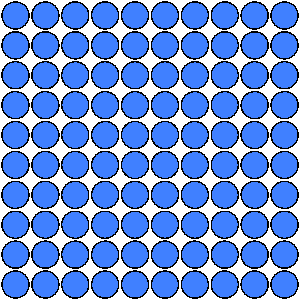

In [9]:
import ex_render
ex_render.display_movie(ex_render.render_disk_frame, 'trajectory.gsd')

## Equilibrate the system

After a sufficient amount of time has passed, the system configurations converge on the thermodynamic equilibrium states. Notice how the disks have equilibrated from a square initial configuration to a hexagonal equilibrium.

** starting run **
Time 00:00:02 | Step 20100 / 20100 | TPS 10491.1 | ETA 00:00:00
Average TPS: 10482.4
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.211093
notice(2): Trial moves per second:        4.19165e+06
notice(2): Overlap checks per second:     5.94544e+07
notice(2): Overlap checks per trial move: 14.184
notice(2): Number of overlap errors:      0
** run complete **
Size: 406.6953125 KiB


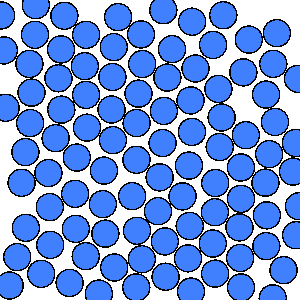

In [10]:
d.disable()
hoomd.run(10000, quiet=True)
d = hoomd.dump.gsd("trajectory.gsd", period=1000, group=hoomd.group.all(), overwrite=True)
hoomd.run(10000)
ex_render.display_movie(ex_render.render_disk_frame, 'trajectory.gsd')

## Parallel HPMC

HPMC supports parallel execution on the GPU, on many CPU cores using MPI, and on many GPUs using MPI. It obeys detailed balance, though the number of trial moves attempted in a time step may differ among parallel configurations. You do not need to modify your job script to take advantage of fast parallel execution. See the MPI tutorial section for more information.